In [19]:
import pandas as pd
import os
from dotenv import load_dotenv
from openai import OpenAI
import hashlib
from tqdm.auto import tqdm


## Dataset generation

Using cosine similarity we aim to evaluate the original answer againts the answer our RAG system is retrieving.

Cosine(A_real, A_generated)

We have a way to evaluate if a prompt is good, or overall the system.


In [38]:
ground_truth = pd.read_csv('ground-truth-data.csv')
ground_truth_unique = ground_truth.drop_duplicates(subset='doc_id', keep='first')

ground_truth = ground_truth_unique.to_dict(orient='records')

## getting the true answer for the question using documents (orignal dataset)

In [10]:
path = '../Data_csvs/data_v1.csv'
df = pd.read_csv(path)
df = df.rename(columns={'id': 'doc_id'})
documents = df.to_dict(orient='records')


def generate_document_id(doc):
    combined = f"{doc['topic']}-{doc['Question']}-{doc['Answer'][:15]}"

    # Create MD5 hash object
    hash_object = hashlib.md5(combined.encode())

    # Get hexadecimal representation
    hash_hex = hash_object.hexdigest()

    # Return first 8 characters as document ID
    document_id = hash_hex[:10]

    return document_id

for doc in documents:
    doc['doc_id'] = generate_document_id(doc)


In [12]:
documents[0]

{'doc_id': '5e34bcbaa8',
 'topic': 'cancer',
 'Question': 'What is (are) Non-Small Cell Lung Cancer ?',
 'Answer': "Key Points Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. There are several types of non-small cell lung cancer. Smoking is the major risk factor for non-small cell lung cancer. Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Tests that examine the lungs are used to detect (find), diagnose, and stage non-small cell lung cancer. Certain factors affect prognosis (chance of recovery) and treatment options. For most patients with non-small cell lung cancer, current treatments do not cure the cancer. Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs in the chest. The lungs bring oxygen into the body as you breathe in. They release carbon dioxide, a waste produc

In [15]:
doc_idx = {d['doc_id']:d for d in documents}
doc_idx['1e40d39b3b']['Answer']

'Key Points Primary central nervous system (CNS) lymphoma is a disease in which malignant (cancer) cells form in the lymph tissue of the brain and/or spinal cord. Having a weakened immune system may increase the risk of developing primary CNS lymphoma. Tests that examine the eyes, brain, and spinal cord are used to detect (find) and diagnose primary CNS lymphoma. Certain factors affect prognosis (chance of recovery) and treatment options. Primary central nervous system (CNS) lymphoma is a disease in which malignant (cancer) cells form in the lymph tissue of the brain and/or spinal cord. Lymphoma is a disease in which malignant (cancer) cells form in the lymph system. The lymph system is part of the immune system and is made up of the lymph, lymph vessels, lymph nodes, spleen, thymus, tonsils, and bone marrow. Lymphocytes (carried in the lymph) travel in and out of the central nervous system (CNS). It is thought that some of these lymphocytes become malignant and cause lymphoma to form 

In [39]:
ground_truth

[{'question': 'What are the main types of non‑small cell lung cancer and how are they identified under a microscope?',
  'doc_id': '5e34bcbaa8'},
 {'question': 'What lifestyle habits increase my chances of developing non‑small cell lung cancer?',
  'doc_id': 'c2845efbbc'},
 {'question': "I've been experiencing a persistent cough and getting short of breath—could these be indicators of non‑small cell lung cancer?",
  'doc_id': 'd1bc99107d'},
 {'question': 'What kinds of exams and scans are used to confirm that someone has non‑small cell lung cancer?',
  'doc_id': 'abdbe99dd2'},
 {'question': 'What are the main elements that doctors consider when estimating a patient’s chance of recovery from non‑small cell lung cancer?',
  'doc_id': '597a81526a'},
 {'question': 'I’m newly diagnosed with non‑small cell lung cancer—what kinds of clinical studies are currently testing new therapies for this disease?',
  'doc_id': '4979172719'},
 {'question': 'What kind of cancer originates in the muscle la

In [40]:
load_dotenv()

# Get the API key
api_key = os.getenv('OPENAI_API_KEY')
print(f"API Key found: {api_key is not None}")

API Key found: True


In [16]:
client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=api_key,
)
def llm(prompt):
    response = client.chat.completions.create(
      extra_body={},
      model="openai/gpt-oss-120b",
      messages=[
        {
          "role": "user",
          "content": prompt
        }
      ]
    )
    return response.choices[0].message.content

In [41]:
answers = {}

for i, rec in tqdm(enumerate(ground_truth)):
    if i in answers:
        continue
    print(rec)
    question = rec['question']
    answer_llm = llm(question)
    doc_id = rec['doc_id']
    print(doc_id)
    original_doc = doc_idx[doc_id]
    print(original_doc)
    answer_orig = original_doc['Answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id
    }


0it [00:00, ?it/s]

{'question': 'What are the main types of non‑small cell lung cancer and how are they identified under a microscope?', 'doc_id': '5e34bcbaa8'}


1it [00:16, 16.32s/it]

5e34bcbaa8
{'doc_id': '5e34bcbaa8', 'topic': 'cancer', 'Question': 'What is (are) Non-Small Cell Lung Cancer ?', 'Answer': "Key Points Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. There are several types of non-small cell lung cancer. Smoking is the major risk factor for non-small cell lung cancer. Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Tests that examine the lungs are used to detect (find), diagnose, and stage non-small cell lung cancer. Certain factors affect prognosis (chance of recovery) and treatment options. For most patients with non-small cell lung cancer, current treatments do not cure the cancer. Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs in the chest. The lungs bring oxygen into the body as you breathe in. They release carbon dioxide, a wast

2it [00:18,  8.13s/it]

c2845efbbc
{'doc_id': 'c2845efbbc', 'topic': 'cancer', 'Question': 'Who is at risk for Non-Small Cell Lung Cancer? ?', 'Answer': "Smoking is the major risk factor for non-small cell lung cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesn't mean that you will not get cancer. Talk to your doctor if you think you may be at risk for lung cancer. Risk factors for lung cancer include the following: Smoking cigarettes, pipes, or cigars, now or in the past. This is the most important risk factor for lung cancer. The earlier in life a person starts smoking, the more often a person smokes, and the more years a person smokes, the greater the risk of lung cancer. Being exposed to secondhand smoke. Being exposed to radiation from any of the following: Radiation therapy to the breast or chest. Radon in the home or workplace. Imaging tests such as CT scans. Atomic bomb rad

3it [00:34, 11.59s/it]

d1bc99107d
{'doc_id': 'd1bc99107d', 'topic': 'cancer', 'Question': 'What are the symptoms of Non-Small Cell Lung Cancer ?', 'Answer': "Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Sometimes lung cancer does not cause any signs or symptoms. It may be found during a chest x-ray done for another condition. Signs and symptoms may be caused by lung cancer or by other conditions. Check with your doctor if you have any of the following: Chest discomfort or pain. A cough that doesnt go away or gets worse over time. Trouble breathing. Wheezing. Blood in sputum (mucus coughed up from the lungs). Hoarseness. Loss of appetite. Weight loss for no known reason. Feeling very tired. Trouble swallowing. Swelling in the face and/or veins in the neck."}
{'question': 'What kinds of exams and scans are used to confirm that someone has non‑small cell lung cancer?', 'doc_id': 'abdbe99dd2'}


4it [01:05, 19.12s/it]

abdbe99dd2
{'doc_id': 'abdbe99dd2', 'topic': 'cancer', 'Question': 'How to diagnose Non-Small Cell Lung Cancer ?', 'Answer': 'Tests that examine the lungs are used to detect (find), diagnose, and stage non-small cell lung cancer. Tests and procedures to detect, diagnose, and stage non-small cell lung cancer are often done at the same time. Some of the following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits, including smoking, and past jobs, illnesses, and treatments will also be taken. Laboratory tests : Medical procedures that test samples of tissue, blood, urine, or other substances in the body. These tests help to diagnose disease, plan and check treatment, or monitor the disease over time. Chest x-ray: An x-ray of the organs and bones inside the chest. An x-ray is a type of energy be

5it [01:21, 18.26s/it]

597a81526a
{'doc_id': '597a81526a', 'topic': 'cancer', 'Question': 'What is the outlook for Non-Small Cell Lung Cancer ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the following: The stage of the cancer (the size of the tumor and whether it is in the lung only or has spread to other places in the body). The type of lung cancer. Whether the cancer has mutations (changes) in certain genes, such as the epidermal growth factor receptor (EGFR) gene or the anaplastic lymphoma kinase (ALK) gene. Whether there are signs and symptoms such as coughing or trouble breathing. The patients general health.'}
{'question': 'I’m newly diagnosed with non‑small cell lung cancer—what kinds of clinical studies are currently testing new therapies for this disease?', 'doc_id': '4979172719'}


6it [01:42, 18.96s/it]

4979172719
{'doc_id': '4979172719', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Non-Small Cell Lung Cancer ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. Chemoprevention Chemoprevention is the use of drugs, vitamins, or other substances to reduce the risk of cancer or to reduce the risk cancer will recur (come back). For lung cancer, chemoprevention is used to lessen the chance that a new tumor will form in the lung. Radiosensitizers Radiosensitizers are substances that make tumor cells easier to kill with radiation therapy. The combination of chemotherapy and radiation therapy given with a radiosensitizer is being studied in the treatment of non-small cell lung cancer. New combinations New combinations of treatme

7it [01:52, 16.00s/it]

d563c7d596
{'doc_id': 'd563c7d596', 'topic': 'cancer', 'Question': 'What is (are) Uterine Sarcoma ?', 'Answer': 'Key Points Uterine sarcoma is a disease in which malignant (cancer) cells form in the muscles of the uterus or other tissues that support the uterus. Being exposed to x-rays can increase the risk of uterine sarcoma. Signs of uterine sarcoma include abnormal bleeding. Tests that examine the uterus are used to detect (find) and diagnose uterine sarcoma. Certain factors affect prognosis (chance of recovery) and treatment options. Uterine sarcoma is a disease in which malignant (cancer) cells form in the muscles of the uterus or other tissues that support the uterus. The uterus is part of the female reproductive system. The uterus is the hollow, pear-shaped organ in the pelvis, where a fetus grows. The cervix is at the lower, narrow end of the uterus, and leads to the vagina. Uterine sarcoma is a very rare kind of cancer that forms in the uterine muscles or in tissues that suppo

8it [01:55, 12.01s/it]

02577e3169
{'doc_id': '02577e3169', 'topic': 'cancer', 'Question': 'Who is at risk for Uterine Sarcoma? ?', 'Answer': 'Being exposed to x-rays can increase the risk of uterine sarcoma. Anything that increases your risk of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesnt mean that you will not get cancer. Talk with your doctor if you think you may be at risk. Risk factors for uterine sarcoma include the following: Past treatment with radiation therapy to the pelvis. Treatment with tamoxifen for breast cancer. If you are taking this drug, have a pelvic exam every year and report any vaginal bleeding (other than menstrual bleeding) as soon as possible.'}
{'question': 'What signs should make me think I might have uterine sarcoma?', 'doc_id': 'd11834721f'}


9it [02:04, 11.04s/it]

d11834721f
{'doc_id': 'd11834721f', 'topic': 'cancer', 'Question': 'What are the symptoms of Uterine Sarcoma ?', 'Answer': 'Signs of uterine sarcoma include abnormal bleeding. Abnormal bleeding from the vagina and other signs and symptoms may be caused by uterine sarcoma or by other conditions. Check with your doctor if you have any of the following: Bleeding that is not part of menstrual periods. Bleeding after menopause. A mass in the vagina. Pain or a feeling of fullness in the abdomen. Frequent urination.'}
{'question': 'What examinations and tests does a doctor use to confirm a diagnosis of uterine sarcoma?', 'doc_id': 'e109719c38'}


10it [02:21, 12.88s/it]

e109719c38
{'doc_id': 'e109719c38', 'topic': 'cancer', 'Question': 'How to diagnose Uterine Sarcoma ?', 'Answer': 'Tests that examine the uterus are used to detect (find) and diagnose uterine sarcoma. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken. Pelvic exam: An exam of the vagina, cervix, uterus, fallopian tubes, ovaries, and rectum. A speculum is inserted into the vagina and the doctor or nurse looks at the vagina and cervix for signs of disease. A Pap test of the cervix is usually done. The doctor or nurse also inserts one or two lubricated, gloved fingers of one hand into the vagina and places the other hand over the lower abdomen to feel the size, shape, and position of the uterus and ovaries. The doctor or nurse al

11it [04:55, 56.24s/it]

6becabff6a
{'doc_id': '6becabff6a', 'topic': 'cancer', 'Question': 'What is the outlook for Uterine Sarcoma ?', 'Answer': "Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the following: The stage of the cancer. The type and size of the tumor. The patient's general health. Whether the cancer has just been diagnosed or has recurred (come back)."}
{'question': 'What kinds of clinical studies are currently available for patients with uterine sarcoma?', 'doc_id': '252662340d'}


12it [05:26, 48.49s/it]

252662340d
{'doc_id': '252662340d', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Uterine Sarcoma ?', 'Answer': "New types of treatment are being tested in clinical trials. Information about clinical trials is available from the NCI website. Patients may want to think about taking part in a clinical trial. For some patients, taking part in a clinical trial may be the best treatment choice. Clinical trials are part of the cancer research process. Clinical trials are done to find out if new cancer treatments are safe and effective or better than the standard treatment. Many of today's standard treatments for cancer are based on earlier clinical trials. Patients who take part in a clinical trial may receive the standard treatment or be among the first to receive a new treatment. Patients who take part in clinical trials also help improve the way cancer will be treated in the future. Even when clinical trials do not lead to effective new treatments, t

13it [05:48, 40.29s/it]

4faee827b1
{'doc_id': '4faee827b1', 'topic': 'cancer', 'Question': 'What is (are) Extragonadal Germ Cell Tumors ?', 'Answer': 'Key Points Extragonadal germ cell tumors form from developing sperm or egg cells that travel from the gonads to other parts of the body. Age and gender can affect the risk of extragonadal germ cell tumors. Signs and symptoms of extragonadal germ cell tumors include breathing problems and chest pain. Imaging and blood tests are used to detect (find) and diagnose extragonadal germ cell tumors. Certain factors affect prognosis (chance of recovery) and treatment options. Extragonadal germ cell tumors form from developing sperm or egg cells that travel from the gonads to other parts of the body. " Extragonadal" means outside of the gonads (sex organs). When cells that are meant to form sperm in the testicles or eggs in the ovaries travel to other parts of the body, they may grow into extragonadal germ cell tumors. These tumors may begin to grow anywhere in the body 

14it [05:59, 31.60s/it]

ee6941d3af
{'doc_id': 'ee6941d3af', 'topic': 'cancer', 'Question': 'Who is at risk for Extragonadal Germ Cell Tumors? ?', 'Answer': 'Age and gender can affect the risk of extragonadal germ cell tumors. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesnt mean that you will not get cancer. Talk with your doctor if you think you may be at risk. Risk factors for malignant extragonadal germ cell tumors include the following: Being male. Being age or older. Having Klinefelter syndrome.'}
{'question': 'I’ve been having chest pain and shortness of breath—could these be signs of an extragonadal germ cell tumor?', 'doc_id': '0867df07b6'}


15it [06:20, 28.45s/it]

0867df07b6
{'doc_id': '0867df07b6', 'topic': 'cancer', 'Question': 'What are the symptoms of Extragonadal Germ Cell Tumors ?', 'Answer': 'Signs and symptoms of extragonadal germ cell tumors include breathing problems and chest pain. Malignant extragonadal germ cell tumors may cause signs and symptoms as they grow into nearby areas. Other conditions may cause the same signs and symptoms. Check with your doctor if you have any of the following: Chest pain. Breathing problems. Cough. Fever. Headache. Change in bowel habits. Feeling very tired. Trouble walking. Trouble in seeing or moving the eyes.'}
{'question': 'What tests are performed to confirm a suspected extragonadal germ cell tumor?', 'doc_id': 'd84a78215e'}


16it [07:39, 43.47s/it]

d84a78215e
{'doc_id': 'd84a78215e', 'topic': 'cancer', 'Question': 'How to diagnose Extragonadal Germ Cell Tumors ?', 'Answer': "Imaging and blood tests are used to detect (find) and diagnose extragonadal germ cell tumors. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. The testicles may be checked for lumps, swelling, or pain. A history of the patient's health habits and past illnesses and treatments will also be taken. Chest x-ray : An x-ray of the organs and bones inside the chest. An x-ray is a type of energy beam that can go through the body and onto film, making a picture of areas inside the body. Serum tumor marker test : A procedure in which a sample of blood is examined to measure the amounts of certain substances released into the blood by organs, tissues, or tumor cells in the body. Certain substances ar

17it [07:54, 35.15s/it]

7cdefbf7d7
{'doc_id': '7cdefbf7d7', 'topic': 'cancer', 'Question': 'What is the outlook for Extragonadal Germ Cell Tumors ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the following: Whether the tumor is nonseminoma or seminoma. The size of the tumor and where it is in the body. The blood levels of AFP, -hCG, and LDH. Whether the tumor has spread to other parts of the body. The way the tumor responds to initial treatment. Whether the tumor has just been diagnosed or has recurred (come back).'}
{'question': 'What are the three prognostic categories used to classify extragonadal germ‑cell tumors and how do they differ from traditional cancer staging?', 'doc_id': 'ef17a8af15'}


18it [08:18, 31.65s/it]

ef17a8af15
{'doc_id': 'ef17a8af15', 'topic': 'cancer', 'Question': 'What are the stages of Extragonadal Germ Cell Tumors ?', 'Answer': 'Key Points After an extragonadal germ cell tumor has been diagnosed, tests are done to find out if cancer cells have spread to other parts of the body. There are three ways that cancer spreads in the body. Cancer may spread from where it began to other parts of the body. The following prognostic groups are used for extragonadal germ cell tumors: Good prognosis Intermediate prognosis Poor prognosis After an extragonadal germ cell tumor has been diagnosed, tests are done to find out if cancer cells have spread to other parts of the body. The extent or spread of cancer is usually described as stages. For extragonadal germ cell tumors, prognostic groups are used instead of stages. The tumors are grouped according to how well the cancer is expected to respond to treatment. It is important to know the prognostic group in order to plan treatment. There are th

19it [09:00, 34.88s/it]

72dbfb80d6
{'doc_id': '72dbfb80d6', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Extragonadal Germ Cell Tumors ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. High-dose chemotherapy with stem cell transplant High-dose chemotherapy with stem cell transplant is a method of giving high doses of chemotherapy and replacing blood -forming cells destroyed by the cancer treatment. Stem cells (immature blood cells) are removed from the blood or bone marrow of the patient or a donor and are frozen and stored. After the chemotherapy is completed, the stored stem cells are thawed and given back to the patient through an infusion. These reinfused stem cells grow into (and restore) the body's blood cells. Patients may want to thi

20it [09:14, 28.40s/it]

ffa3a8b71c
{'doc_id': 'ffa3a8b71c', 'topic': 'cancer', 'Question': 'What is (are) Endometrial Cancer ?', 'Answer': "Key Points Endometrial cancer is a disease in which malignant (cancer) cells form in the tissues of the endometrium. In the United States, endometrial cancer is the most common invasive cancer of the female reproductive system. Health history and certain medicines can affect the risk of developing endometrial cancer. Endometrial cancer is a disease in which malignant (cancer) cells form in the tissues of the endometrium. The endometrium is the innermost lining of the uterus. The uterus is a hollow, muscular organ in a woman's pelvis. The uterus is where a fetus grows. In most nonpregnant women, the uterus is about inches long. Cancer of the endometrium is different from cancer of the muscle of the uterus, which is called uterine sarcoma. See the PDQ summary on Uterine Sarcoma Treatment for more information. See the following PDQ summaries for more information about endome

21it [09:50, 30.84s/it]

5571edf550
{'doc_id': '5571edf550', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Endometrial Cancer ?', 'Answer': "Cancer prevention clinical trials are used to study ways to prevent cancer. Cancer prevention clinical trials are used to study ways to lower the risk of developing certain types of cancer. Some cancer prevention trials are conducted with healthy people who have not had cancer but who have an increased risk for cancer. Other prevention trials are conducted with people who have had cancer and are trying to prevent another cancer of the same type or to lower their chance of developing a new type of cancer. Other trials are done with healthy volunteers who are not known to have any risk factors for cancer. The purpose of some cancer prevention clinical trials is to find out whether actions people take can prevent cancer. These may include eating fruits and vegetables, exercising, quitting smoking, or taking certain medicines, vitamins, 

22it [10:09, 27.10s/it]

088527fd30
{'doc_id': '088527fd30', 'topic': 'cancer', 'Question': 'Who is at risk for Endometrial Cancer? ?', 'Answer': "Obesity and having metabolic syndrome may increase the risk of endometrial cancer. Anything that increases your risk of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesn't mean that you will not get cancer. Talk with your doctor if you think you may be at risk. Risk factors for endometrial cancer include the following: Having endometrial hyperplasia. Being obese. Having metabolic syndrome, a set of conditions that occur together, including extra fat around the abdomen, high blood sugar, high blood pressure, high levels of triglycerides and low levels of high-density lipoproteins in the blood. Never giving birth. Beginning menstruation at an early age. Reaching menopause at an older age. Having polycystic ovarian syndrome (PCOS). Having a mother, sister, or daughter with uterine cance

23it [10:23, 23.21s/it]

de8d113e10
{'doc_id': 'de8d113e10', 'topic': 'cancer', 'Question': 'What are the symptoms of Endometrial Cancer ?', 'Answer': 'Signs and symptoms of endometrial cancer include unusual vaginal bleeding or pain in the pelvis. These and other signs and symptoms may be caused by endometrial cancer or by other conditions. Check with your doctor if you have any of the following: Vaginal bleeding or discharge not related to menstruation (periods). Vaginal bleeding after menopause. Difficult or painful urination. Pain during sexual intercourse. Pain in the pelvic area.'}
{'question': 'What tests will my doctor use to find out if I have endometrial cancer?', 'doc_id': '6382ed5025'}


24it [10:49, 24.01s/it]

6382ed5025
{'doc_id': '6382ed5025', 'topic': 'cancer', 'Question': 'How to diagnose Endometrial Cancer ?', 'Answer': 'Tests that examine the endometrium are used to detect (find) and diagnose endometrial cancer. Because endometrial cancer begins inside the uterus, it does not usually show up in the results of a Pap test. For this reason, a sample of endometrial tissue must be removed and checked under a microscope to look for cancer cells. One of the following procedures may be used: Endometrial biopsy : The removal of tissue from the endometrium (inner lining of the uterus) by inserting a thin, flexible tube through the cervix and into the uterus. The tube is used to gently scrape a small amount of tissue from the endometrium and then remove the tissue samples. A pathologist views the tissue under a microscope to look for cancer cells. Dilatation and curettage : A procedure to remove samples of tissue from the inner lining of the uterus. The cervix is dilated and a curette (spoon-shap

25it [11:01, 20.50s/it]

58a1402850
{'doc_id': '58a1402850', 'topic': 'cancer', 'Question': 'What is the outlook for Endometrial Cancer ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options.The prognosis (chance of recovery) and treatment options depend on the following: The stage of the cancer (whether it is in the endometrium only, involves the uterus wall, or has spread to other places in the body). How the cancer cells look under a microscope. Whether the cancer cells are affected by progesterone. Endometrial cancer can usually be cured because it is usually diagnosed early.'}
{'question': 'Are there any ongoing clinical trials that I could enroll in for my endometrial cancer?', 'doc_id': '621ffb7c2b'}


26it [11:37, 25.29s/it]

621ffb7c2b
{'doc_id': '621ffb7c2b', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Endometrial Cancer ?', 'Answer': "New types of treatment are being tested in clinical trials. Information about clinical trials is available from the NCI website. Patients may want to think about taking part in a clinical trial. For some patients, taking part in a clinical trial may be the best treatment choice. Clinical trials are part of the cancer research process. Clinical trials are done to find out if new cancer treatments are safe and effective or better than the standard treatment. Many of today's standard treatments for cancer are based on earlier clinical trials. Patients who take part in a clinical trial may receive the standard treatment or be among the first to receive a new treatment. Patients who take part in clinical trials also help improve the way cancer will be treated in the future. Even when clinical trials do not lead to effective new treatments

27it [11:48, 20.86s/it]

8f023665d0
{'doc_id': '8f023665d0', 'topic': 'cancer', 'Question': 'What is (are) Small Cell Lung Cancer ?', 'Answer': 'Key Points Small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. There are two main types of small cell lung cancer. Smoking is the major risk factor for small cell lung cancer. Signs and symptoms of small cell lung cancer include coughing, shortness of breath, and chest pain. Tests and procedures that examine the lungs are used to detect (find), diagnose, and stage small cell lung cancer. Certain factors affect prognosis (chance of recovery) and treatment options. For most patients with small cell lung cancer, current treatments do not cure the cancer. Small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs that are found in the chest. The lungs bring oxygen into the body when you breathe in and take out carbon dioxide w

28it [11:57, 17.40s/it]

9cdbb2c4d0
{'doc_id': '9cdbb2c4d0', 'topic': 'cancer', 'Question': 'Who is at risk for Small Cell Lung Cancer? ?', 'Answer': "Smoking is the major risk factor for small cell lung cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesn't mean that you will not get cancer. Talk to your doctor if you think you may be at risk for lung cancer. Risk factors for lung cancer include the following: Smoking cigarettes, pipes, or cigars, now or in the past. This is the most important risk factor for lung cancer. The earlier in life a person starts smoking, the more often a person smokes, and the more years a person smokes, the greater the risk of lung cancer. Being exposed to secondhand smoke. Being exposed to radiation from any of the following: Radiation therapy to the breast or chest. Radon in the home or workplace. Imaging tests such as CT scans. Atomic bomb radiation. 

29it [12:12, 16.60s/it]

a1202c549f
{'doc_id': 'a1202c549f', 'topic': 'cancer', 'Question': 'What are the symptoms of Small Cell Lung Cancer ?', 'Answer': 'Signs and symptoms of small cell lung cancer include coughing, shortness of breath, and chest pain. These and other signs and symptoms may be caused by small cell lung cancer or by other conditions. Check with your doctor if you have any of the following: Chest discomfort or pain. A cough that doesnt go away or gets worse over time. Trouble breathing. Wheezing. Blood in sputum (mucus coughed up from the lungs). Hoarseness. Trouble swallowing. Loss of appetite. Weight loss for no known reason. Feeling very tired. Swelling in the face and/or veins in the neck.'}
{'question': 'What tests will my doctor use to determine if I have small cell lung cancer?', 'doc_id': '848ba6d56e'}


30it [12:46, 21.82s/it]

848ba6d56e
{'doc_id': '848ba6d56e', 'topic': 'cancer', 'Question': 'How to diagnose Small Cell Lung Cancer ?', 'Answer': 'Tests and procedures that examine the lungs are used to detect (find), diagnose, and stage small cell lung cancer. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits, including smoking, and past jobs, illnesses, and treatments will also be taken. Laboratory tests : Medical procedures that test samples of tissue, blood, urine, or other substances in the body. These tests help to diagnose disease, plan and check treatment, or monitor the disease over time. Chest x-ray : An x-ray of the organs and bones inside the chest. An x-ray is a type of energy beam that can go through the body and onto film, making a picture of areas inside the body. CT scan (CAT scan) of 

31it [12:59, 19.21s/it]

679cfc087d
{'doc_id': '679cfc087d', 'topic': 'cancer', 'Question': 'What are the stages of Small Cell Lung Cancer ?', 'Answer': 'Key Points After small cell lung cancer has been diagnosed, tests are done to find out if cancer cells have spread within the chest or to other parts of the body. There are three ways that cancer spreads in the body. Cancer may spread from where it began to other parts of the body. The following stages are used for small cell lung cancer: Limited-Stage Small Cell Lung Cancer Extensive-Stage Small Cell Lung Cancer After small cell lung cancer has been diagnosed, tests are done to find out if cancer cells have spread within the chest or to other parts of the body. The process used to find out if cancer has spread within the chest or to other parts of the body is called staging. The information gathered from the staging process determines the stage of the disease. It is important to know the stage in order to plan treatment. Some of the tests used to diagnose sm

32it [13:03, 14.67s/it]

ef336b61e4
{'doc_id': 'ef336b61e4', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Small Cell Lung Cancer ?', 'Answer': "New types of treatment are being tested in clinical trials. Information about clinical trials is available from the NCI website. Patients may want to think about taking part in a clinical trial. For some patients, taking part in a clinical trial may be the best treatment choice. Clinical trials are part of the cancer research process. Clinical trials are done to find out if new cancer treatments are safe and effective or better than the standard treatment. Many of today's standard treatments for cancer are based on earlier clinical trials. Patients who take part in a clinical trial may receive the standard treatment or be among the first to receive a new treatment. Patients who take part in clinical trials also help improve the way cancer will be treated in the future. Even when clinical trials do not lead to effective new treatm

33it [13:36, 20.17s/it]

101bdffe00
{'doc_id': '101bdffe00', 'topic': 'cancer', 'Question': 'Who is at risk for Plasma Cell Neoplasms (Including Multiple Myeloma)? ?', 'Answer': "Age can affect the risk of plasma cell neoplasms. Anything that increases your risk of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesn't mean that you will not get cancer. Talk with your doctor if you think you may be at risk. Plasma cell neoplasms are most common in people who are middle aged or older. For multiple myeloma and plasmacytoma, other risk factors include the following: Being black. Being male. Having a personal history of MGUS or plasmacytoma. Being exposed to radiation or certain chemicals."}
{'question': 'What laboratory tests are typically ordered to detect multiple myeloma or other plasma‑cell cancers?', 'doc_id': '351788cb7a'}


34it [13:53, 19.24s/it]

351788cb7a
{'doc_id': '351788cb7a', 'topic': 'cancer', 'Question': 'How to diagnose Plasma Cell Neoplasms (Including Multiple Myeloma) ?', 'Answer': 'Tests that examine the blood, bone marrow, and urine are used to detect (find) and diagnose multiple myeloma and other plasma cell neoplasms. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken. Blood and urine immunoglobulin studies: A procedure in which a blood or urine sample is checked to measure the amounts of certain antibodies (immunoglobulins). For multiple myeloma, beta-2-microglobulin, M protein, free light chains, and other proteins made by the myeloma cells are measured. A higher-than-normal amount of these substances can be a sign of disease. Bone marrow aspiration an

35it [14:36, 26.19s/it]

517275c519
{'doc_id': '517275c519', 'topic': 'cancer', 'Question': 'What is the outlook for Plasma Cell Neoplasms (Including Multiple Myeloma) ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) depends on the following: The type of plasma cell neoplasm. The stage of the disease. Whether a certain immunoglobulin (antibody) is present. Whether there are certain genetic changes. Whether the kidney is damaged. Whether the cancer responds to initial treatment or recurs (comes back). Treatment options depend on the following: The type of plasma cell neoplasm. The age and general health of the patient. Whether there are signs, symptoms, or health problems, such as kidney failure or infection, related to the disease. Whether the cancer responds to initial treatment or recurs (comes back).'}
{'question': 'How is multiple myeloma staged and which blood markers define each stage?', 'doc_id': '021ee8a0ee'}


36it [14:44, 20.80s/it]

021ee8a0ee
{'doc_id': '021ee8a0ee', 'topic': 'cancer', 'Question': 'What are the stages of Plasma Cell Neoplasms (Including Multiple Myeloma) ?', 'Answer': 'Key Points There are no standard staging systems for monoclonal gammopathy of undetermined significance (MGUS), macroglobulinemia, and plasmacytoma. After multiple myeloma has been diagnosed, tests are done to find out the amount of cancer in the body. The stage of multiple myeloma is based on the levels of beta-2-microglobulin and albumin in the blood. The following stages are used for multiple myeloma: Stage I multiple myeloma Stage II multiple myeloma Stage III multiple myeloma There are no standard staging systems for monoclonal gammopathy of undetermined significance (MGUS), macroglobulinemia, and plasmacytoma. After multiple myeloma has been diagnosed, tests are done to find out the amount of cancer in the body. The process used to find out the amount of cancer in the body is called staging. It is important to know the stage 

37it [15:12, 23.09s/it]

7d750489ed
{'doc_id': '7d750489ed', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Plasma Cell Neoplasms (Including Multiple Myeloma) ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. New combinations of therapies Clinical trials are studying different combinations of biologic therapy, chemotherapy, steroid therapy, and drugs. New treatment regimens using thalidomide or lenalidomide are also being studied. Supportive care is given to lessen the problems caused by the disease or its treatment. This therapy controls problems or side effects caused by the disease or its treatment, and improves quality of life. Supportive care is given to treat problems caused by multiple myeloma and other plasma cell neoplasms. Supportive 

38it [15:34, 22.62s/it]

78cb73d0e8
{'doc_id': '78cb73d0e8', 'topic': 'cancer', 'Question': 'What is (are) Lung Cancer ?', 'Answer': 'Key Points Lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. Lung cancer is the leading cause of cancer death in the United States. Different factors increase or decrease the risk of lung cancer. Lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs inside the chest. The lungs bring oxygen into the body when breathing in and send carbon dioxide out of the body when breathing out. Each lung has sections called lobes. The left lung has two lobes. The right lung, which is slightly larger, has three. A thin membrane called the pleura surrounds the lungs. Two tubes called bronchi lead from the trachea (windpipe) to the right and left lungs. The bronchi are sometimes involved in lung cancer. Small tubes called bronchioles and tiny air sacs called alveoli

39it [15:43, 18.47s/it]

bac6b4c5cc
{'doc_id': 'bac6b4c5cc', 'topic': 'cancer', 'Question': 'What is (are) Prostate Cancer ?', 'Answer': 'Key Points Prostate cancer is a disease in which malignant (cancer) cells form in the tissues of the prostate. Signs of prostate cancer include a weak flow of urine or frequent urination. Tests that examine the prostate and blood are used to detect (find) and diagnose prostate cancer. Certain factors affect prognosis (chance of recovery) and treatment options. Prostate cancer is a disease in which malignant (cancer) cells form in the tissues of the prostate. The prostate is a gland in the male reproductive system. It lies just below the bladder (the organ that collects and empties urine) and in front of the rectum (the lower part of the intestine). It is about the size of a walnut and surrounds part of the urethra (the tube that empties urine from the bladder). The prostate gland makes fluid that is part of the semen. Prostate cancer is most common in older men. In the U.S.,

40it [18:02, 54.68s/it]

402da42b54
{'doc_id': '402da42b54', 'topic': 'cancer', 'Question': 'Who is at risk for Prostate Cancer? ?', 'Answer': 'Prostate cancer is most common in older men. In the U.S., about one out of five men will be diagnosed with prostate cancer. Most men diagnosed with prostate cancer do not die of it. See the following PDQ summaries for more information about prostate cancer: Prostate Cancer Screening Prostate Cancer Treatment'}
{'question': 'What lifestyle or health factors might make me more likely to develop prostate cancer?', 'doc_id': '68984b7525'}


41it [18:14, 42.08s/it]

68984b7525
{'doc_id': '68984b7525', 'topic': 'cancer', 'Question': 'Who is at risk for Prostate Cancer? ?', 'Answer': "Different factors increase or decrease the risk of developing prostate cancer. Anything that increases a person's chance of developing a disease is called a risk factor. Anything that decreases your chance of getting a disease is called a protective factor. For information about risk factors and protective factors for prostate cancer, see the PDQ summary on Prostate Cancer Prevention."}
{'question': "How would you define penile cancer in layman's terms?", 'doc_id': 'ba64453a09'}


42it [18:24, 32.21s/it]

ba64453a09
{'doc_id': 'ba64453a09', 'topic': 'cancer', 'Question': 'What is (are) Penile Cancer ?', 'Answer': 'Key Points Penile cancer is a disease in which malignant (cancer) cells form in the tissues of the penis. Human papillomavirus infection may increase the risk of developing penile cancer. Signs of penile cancer include sores, discharge, and bleeding. Tests that examine the penis are used to detect (find) and diagnose penile cancer. Certain factors affect prognosis (chance of recovery) and treatment options. Penile cancer is a disease in which malignant (cancer) cells form in the tissues of the penis. The penis is a rod-shaped male reproductive organ that passes sperm and urine from the body. It contains two types of erectile tissue (spongy tissue with blood vessels that fill with blood to make an erection): Corpora cavernosa: The two columns of erectile tissue that form most of the penis. Corpus spongiosum: The single column of erectile tissue that forms a small portion of the

43it [18:45, 29.02s/it]

06e098f459
{'doc_id': '06e098f459', 'topic': 'cancer', 'Question': 'Who is at risk for Penile Cancer? ?', 'Answer': "Human papillomavirus infection may increase the risk of developing penile cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesn't mean that you will not get cancer. Talk with your doctor if you think you may be at risk. Risk factors for penile cancer include the following: Circumcision may help prevent infection with the human papillomavirus (HPV). A circumcision is an operation in which the doctor removes part or all of the foreskin from the penis. Many boys are circumcised shortly after birth. Men who were not circumcised at birth may have a higher risk of developing penile cancer. Other risk factors for penile cancer include the following: Being age or older. Having phimosis (a condition in which the foreskin of the penis cannot be pulled back

44it [19:10, 27.62s/it]

de1d276609
{'doc_id': 'de1d276609', 'topic': 'cancer', 'Question': 'What are the symptoms of Penile Cancer ?', 'Answer': 'Signs of penile cancer include sores, discharge, and bleeding. These and other signs may be caused by penile cancer or by other conditions. Check with your doctor if you have any of the following: Redness, irritation, or a sore on the penis. A lump on the penis.'}
{'question': 'What examinations and tests are performed to confirm a diagnosis of penile cancer?', 'doc_id': '792a2e7a73'}


45it [19:44, 29.62s/it]

792a2e7a73
{'doc_id': '792a2e7a73', 'topic': 'cancer', 'Question': 'How to diagnose Penile Cancer ?', 'Answer': "Tests that examine the penis are used to detect (find) and diagnose penile cancer. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking the penis for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken. Biopsy : The removal of cells or tissues so they can be viewed under a microscope by a pathologist to check for signs of cancer. The tissue sample is removed during one of the following procedures: Fine-needle aspiration (FNA) biopsy : The removal of tissue or fluid using a thin needle. Incisional biopsy : The removal of part of a lump or a sample of tissue that doesn't look normal. Excisional biopsy : The removal of an entire lump or area of tissue that doesnt look normal.

46it [19:54, 23.88s/it]

b30481aa08
{'doc_id': 'b30481aa08', 'topic': 'cancer', 'Question': 'What is the outlook for Penile Cancer ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the following: The stage of the cancer. The location and size of the tumor. Whether the cancer has just been diagnosed or has recurred (come back).'}
{'question': 'What types of clinical trials are being conducted to test new treatments for penile cancer?', 'doc_id': '7aebe89d79'}


47it [20:25, 26.01s/it]

7aebe89d79
{'doc_id': '7aebe89d79', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Penile Cancer ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. Radiosensitizers Radiosensitizers are drugs that make tumor cells more sensitive to radiation therapy. Combining radiation therapy with radiosensitizers helps kill more tumor cells. Sentinel lymph node biopsy followed by surgery Sentinel lymph node biopsy is the removal of the sentinel lymph node during surgery. The sentinel lymph node is the first lymph node to receive lymphatic drainage from a tumor. It is the first lymph node the cancer is likely to spread to from the tumor. A radioactive substance and/or blue dye is injected near the tumor. The substance or dye flows thro

48it [20:40, 22.70s/it]

4f689fb989
{'doc_id': '4f689fb989', 'topic': 'cancer', 'Question': 'Who is at risk for Endometrial Cancer? ?', 'Answer': 'Health history and certain medicines can affect the risk of developing endometrial cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesnt mean that you will not get cancer. People who think they may be at risk should discuss this with their doctor. Risk factors for endometrial cancer include the following: Taking tamoxifen for treatment or prevention of breast cancer. Taking estrogen alone. (Taking estrogen in combination with progestin does not appear to increase the risk of endometrial cancer.) Being overweight. Eating a high-fat diet. Never giving birth. Beginning menstruation at an early age. Reaching menopause at an older age. Having the gene for hereditary non-polyposis colon cancer (HNPCC). Being white.'}
{'question': 'Can you explain

49it [21:02, 22.52s/it]

e7040f9158
{'doc_id': 'e7040f9158', 'topic': 'cancer', 'Question': 'What is (are) Ewing Sarcoma ?', 'Answer': 'Key Points Ewing sarcoma is a type of tumor that forms in bone or soft tissue. Signs and symptoms of Ewing sarcoma include swelling and pain near the tumor. Tests that examine the bone and soft tissue are used to diagnose and stage Ewing sarcoma. A biopsy is done to diagnose Ewing sarcoma. Certain factors affect prognosis (chance of recovery). Ewing sarcoma is a type of tumor that forms in bone or soft tissue. Ewing sarcoma is a type of tumor that forms from a certain kind of cell in bone or soft tissue. Ewing sarcoma may be found in the bones of the legs, arms, feet, hands, chest, pelvis, spine, or skull. Ewing sarcoma also may be found in the soft tissue of the trunk, arms, legs, head and neck, abdominal cavity, or other areas. Ewing sarcoma is most common in adolescents and young adults. Ewing sarcoma has also been called peripheral primitive neuroectodermal tumor, Askin tu

50it [21:10, 18.10s/it]

ee839abe91
{'doc_id': 'ee839abe91', 'topic': 'cancer', 'Question': 'What are the symptoms of Ewing Sarcoma ?', 'Answer': 'Signs and symptoms of Ewing sarcoma include swelling and pain near the tumor. These and other signs and symptoms may be caused by Ewing sarcoma or by other conditions. Check with your childs doctor if your child has any of the following: Pain and/or swelling, usually in the arms, legs, chest, back, or pelvis. A lump (which may feel soft and warm) in the arms, legs, chest, or pelvis. Fever for no known reason. A bone that breaks for no known reason.'}
{'question': 'What factors are considered when estimating the prognosis for a newly diagnosed Ewing sarcoma?', 'doc_id': '63b47d2f2f'}


51it [21:31, 18.90s/it]

63b47d2f2f
{'doc_id': '63b47d2f2f', 'topic': 'cancer', 'Question': 'What is the outlook for Ewing Sarcoma ?', 'Answer': "Certain factors affect prognosis (chance of recovery). The factors that affect prognosis (chance of recovery) are different before and after treatment. Before treatment, prognosis depends on: Whether the tumor has spread to lymph nodes or distant parts of the body. Where in the body the tumor started. Whether the tumor formed in the bone or in soft tissue. How large the tumor is at when the tumor is diagnosed. Whether the LDH level in the blood is higher than normal. Whether the tumor has certain gene changes. Whether the child is younger than years. The patient's gender. Whether the child has had treatment for a different cancer before Ewing sarcoma. Whether the tumor has just been diagnosed or has recurred (come back). After treatment, prognosis is affected by: Whether the tumor was completely removed by surgery. Whether the tumor responds to chemotherapy or radiat

52it [25:39, 87.51s/it]

05a786995a
{'doc_id': '05a786995a', 'topic': 'cancer', 'Question': 'What are the stages of Ewing Sarcoma ?', 'Answer': 'Key Points The results of diagnostic and staging tests are used to find out if cancer cells have spread. Ewing sarcoma is described based on whether the cancer has spread from the bone or soft tissue in which the cancer began. Localized Ewing sarcoma Metastatic Ewing sarcoma There are three ways that cancer spreads in the body. Cancer may spread from where it began to other parts of the body. The results of diagnostic and staging tests are used to find out if cancer cells have spread. The process used to find out if cancer has spread from where it began to other parts of the body is called staging. There is no standard staging system for Ewing sarcoma. The results of the tests and procedures done to diagnose and stage Ewing sarcoma are used to group the tumors into localized or metastatic. Ewing sarcoma is described based on whether the cancer has spread from the bone

53it [26:50, 82.63s/it]

4fdc89ef9c
{'doc_id': '4fdc89ef9c', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Ewing Sarcoma ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. Chimeric antigen receptor (CAR) T-cell therapy CAR T-cell therapy is a type of immunotherapy that changes the patient's T cells (a type of immune system cell) so they will attack certain proteins on the surface of cancer cells. T cells are taken from the patient and special receptors are added to their surface in the laboratory. The changed cells are called chimeric antigen receptor (CAR) T cells. The CAR T cells are grown in the laboratory and given to the patient by infusion. The CAR T cells multiply in the patient's blood and attack cancer cells. CAR T-cell therapy is bein

54it [27:10, 63.86s/it]

666ff1c907
{'doc_id': '666ff1c907', 'topic': 'cancer', 'Question': 'What is (are) Gastrointestinal Carcinoid Tumors ?', 'Answer': "Key Points A gastrointestinal carcinoid tumor is cancer that forms in the lining of the gastrointestinal tract. Health history can affect the risk of gastrointestinal carcinoid tumors. Some gastrointestinal carcinoid tumors have no signs or symptoms in the early stages. Carcinoid syndrome may occur if the tumor spreads to the liver or other parts of the body. Imaging studies and tests that examine the blood and urine are used to detect (find) and diagnose gastrointestinal carcinoid tumors. Certain factors affect prognosis (chance of recovery) and treatment options. A gastrointestinal carcinoid tumor is cancer that forms in the lining of the gastrointestinal tract. The gastrointestinal (GI) tract is part of the body's digestive system. It helps to digest food, takes nutrients (vitamins, minerals, carbohydrates, fats, proteins, and water) from food to be used

55it [27:27, 49.80s/it]

84753cffcf
{'doc_id': '84753cffcf', 'topic': 'cancer', 'Question': 'Who is at risk for Gastrointestinal Carcinoid Tumors? ?', 'Answer': "Health history can affect the risk of gastrointestinal carcinoid tumors. Anything that increases a person's chance of developing a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesnt mean that you will not get cancer. Talk to your doctor if you think you may be at risk. Risk factors for GI carcinoid tumors include the following: Having a family history of multiple endocrine neoplasia type (MEN1) syndrome or neurofibromatosis type (NF1) syndrome. Having certain conditions that affect the stomach's ability to make stomach acid, such as atrophic gastritis, pernicious anemia, or Zollinger-Ellison syndrome."}
{'question': 'What kinds of symptoms might appear in someone with a carcinoid tumor of the duodenum?', 'doc_id': '5b989f685e'}


56it [27:28, 35.26s/it]

5b989f685e
{'doc_id': '5b989f685e', 'topic': 'cancer', 'Question': 'What are the symptoms of Gastrointestinal Carcinoid Tumors ?', 'Answer': 'Some gastrointestinal carcinoid tumors have no signs or symptoms in the early stages.Signs and symptoms may be caused by the growth of the tumor and/or the hormones the tumor makes. Some tumors, especially tumors of the stomach or appendix, may not cause signs or symptoms. Carcinoid tumors are often found during tests or treatments for other conditions. Carcinoid tumors in the small intestine (duodenum, jejunum, and ileum), colon, and rectum sometimes cause signs or symptoms as they grow or because of the hormones they make. Other conditions may cause the same signs or symptoms. Check with your doctor if you have any of the following: Duodenum Signs and symptoms of GI carcinoid tumors in the duodenum (first part of the small intestine, that connects to the stomach) may include the following: Abdominal pain. Constipation. Diarrhea. Change in stool

57it [27:58, 33.65s/it]

2395b08c9d
{'doc_id': '2395b08c9d', 'topic': 'cancer', 'Question': 'How to diagnose Gastrointestinal Carcinoid Tumors ?', 'Answer': 'Imaging studies and tests that examine the blood and urine are used to detect (find) and diagnose gastrointestinal carcinoid tumors. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken. Blood chemistry studies : A procedure in which a blood sample is checked to measure the amounts of certain substances, such as hormones, released into the blood by organs and tissues in the body. An unusual (higher or lower than normal) amount of a substance can be a sign of disease. The blood sample is checked to see if it contains a hormone produced by carcinoid tumors. This test is used to help diagnose carcinoi

58it [28:30, 33.25s/it]

5b4df37f97
{'doc_id': '5b4df37f97', 'topic': 'cancer', 'Question': 'What is the outlook for Gastrointestinal Carcinoid Tumors ?', 'Answer': 'Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the following: Where the tumor is in the gastrointestinal tract. The size of the tumor. Whether the cancer has spread from the stomach and intestines to other parts of the body, such as the liver or lymph nodes. Whether the patient has carcinoid syndrome or has carcinoid heart syndrome. Whether the cancer can be completely removed by surgery. Whether the cancer is newly diagnosed or has recurred.'}
{'question': 'What are the different stages used to classify a gastrointestinal carcinoid tumor?', 'doc_id': '1a153b2861'}


59it [28:51, 29.34s/it]

1a153b2861
{'doc_id': '1a153b2861', 'topic': 'cancer', 'Question': 'What are the stages of Gastrointestinal Carcinoid Tumors ?', 'Answer': 'Key Points After a gastrointestinal carcinoid tumor has been diagnosed, tests are done to find out if cancer cells have spread within the stomach and intestines or to other parts of the body. There are three ways that cancer spreads in the body. Cancer may spread from where it began to other parts of the body. The plan for cancer treatment depends on where the carcinoid tumor is found and whether it can be removed by surgery. After a gastrointestinal carcinoid tumor has been diagnosed, tests are done to find out if cancer cells have spread within the stomach and intestines or to other parts of the body. Staging is the process used to find out how far the cancer has spread. The information gathered from the staging process determines the stage of the disease. The results of tests and procedures used to diagnose gastrointestinal (GI) carcinoid tumors

60it [29:04, 24.65s/it]

98f235d858
{'doc_id': '98f235d858', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Gastrointestinal Carcinoid Tumors ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about clinical trials is available from the NCI website. Targeted therapy Targeted therapy is a type of treatment that uses drugs or other substances to identify and attack specific cancer cells without harming normal cells. Several types of targeted therapy are being studied in the treatment of GI carcinoid tumors. Patients may want to think about taking part in a clinical trial. For some patients, taking part in a clinical trial may be the best treatment choice. Clinical trials are part of the cancer research process. Clinical trials are done to find out if new cancer treatments are safe and effective or bette

61it [29:49, 30.65s/it]

7ed2cc926d
{'doc_id': '7ed2cc926d', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Prostate Cancer ?', 'Answer': "Cancer prevention clinical trials are used to study ways to prevent cancer. Cancer prevention clinical trials are used to study ways to lower the risk of developing certain types of cancer. Some cancer prevention trials are conducted with healthy people who have not had cancer but who have an increased risk for cancer. Other prevention trials are conducted with people who have had cancer and are trying to prevent another cancer of the same type or to lower their chance of developing a new type of cancer. Other trials are done with healthy volunteers who are not known to have any risk factors for cancer. The purpose of some cancer prevention clinical trials is to find out whether actions people take can prevent cancer. These may include eating fruits and vegetables, exercising, quitting smoking, or taking certain medicines, vitamins, min

62it [30:28, 33.06s/it]

bca43ab353
{'doc_id': 'bca43ab353', 'topic': 'cancer', 'Question': 'Who is at risk for Lung Cancer? ?', 'Answer': "Different factors increase or decrease the risk of lung cancer. Anything that increases your chance of getting a disease is called a risk factor. Anything that decreases your chance of getting a disease is called a protective factor. For information about risk factors and protective factors for lung cancer, see the PDQ summary on Lung Cancer Prevention. Key Points Screening tests have risks. The risks of lung cancer screening tests include the following: Finding lung cancer may not improve health or help you live longer. False-negative test results can occur. False-positive test results can occur. Chest x-rays and low-dose spiral CT scans expose the chest to radiation. Talk to your doctor about your risk for lung cancer and your need for screening tests. Screening tests have risks. Decisions about screening tests can be difficult. Not all screening tests are helpful and mo

63it [30:33, 24.78s/it]

18c27cebfd
{'doc_id': '18c27cebfd', 'topic': 'cancer', 'Question': 'What is (are) Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': 'Key Points Osteosarcoma and malignant fibrous histiocytoma (MFH) of the bone are diseases in which malignant (cancer) cells form in bone. Having past treatment with radiation can increase the risk of osteosarcoma. Signs and symptoms of osteosarcoma and MFH include swelling over a bone or a bony part of the body and joint pain. Imaging tests are used to detect (find) osteosarcoma and MFH. A biopsy is done to diagnose osteosarcoma. Certain factors affect prognosis (chance of recovery) and treatment options. Osteosarcoma and malignant fibrous histiocytoma (MFH) of the bone are diseases in which malignant (cancer) cells form in bone. Osteosarcoma usually starts in osteoblasts, which are a type of bone cell that becomes new bone tissue. Osteosarcoma is most common in adolescents. It commonly forms in the ends of the long bones of the body, 

64it [30:45, 20.90s/it]

d03922592e
{'doc_id': 'd03922592e', 'topic': 'cancer', 'Question': 'Who is at risk for Osteosarcoma and Malignant Fibrous Histiocytoma of Bone? ?', 'Answer': "Having past treatment with radiation can increase the risk of osteosarcoma. Anything that increases your risk of getting a disease is called a risk factor. Having a risk factor does not mean that you will get cancer; not having risk factors doesnt mean that you will not get cancer. Talk with your child's doctor if you think your child may be at risk. Risk factors for osteosarcoma include the following: Past treatment with radiation therapy. Past treatment with anticancer drugs called alkylating agents. Having a certain change in the retinoblastoma gene. Having certain conditions, such as the following: Bloom syndrome. Diamond-Blackfan anemia. Li-Fraumeni syndrome. Paget disease. Hereditary retinoblastoma. Rothmund-Thomson syndrome. Werner syndrome."}
{'question': 'What signs should I look for that might indicate osteosarcoma or m

65it [30:55, 17.62s/it]

0909b9679e
{'doc_id': '0909b9679e', 'topic': 'cancer', 'Question': 'What are the symptoms of Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': 'Signs and symptoms of osteosarcoma and MFH include swelling over a bone or a bony part of the body and joint pain. These and other signs and symptoms may be caused by osteosarcoma or MFH or by other conditions. Check with a doctor if your child has any of the following: Swelling over a bone or bony part of the body. Pain in a bone or joint. A bone that breaks for no known reason.'}
{'question': 'What imaging studies are typically ordered before a biopsy when doctors suspect a bone tumor such as osteosarcoma or malignant fibrous histiocytoma?', 'doc_id': '04ef882194'}


66it [31:08, 16.20s/it]

04ef882194
{'doc_id': '04ef882194', 'topic': 'cancer', 'Question': 'How to diagnose Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': "Imaging tests are used to detect (find) osteosarcoma and MFH. Imaging tests are done before the biopsy. The following tests and procedures may be used: Physical exam and history : An exam of the body to check general signs of health, including checking for signs of disease, such as lumps or anything else that seems unusual. A history of the patients health habits and past illnesses and treatments will also be taken. X-ray : An x-ray of the organs and bones inside the body. An x-ray is a type of energy beam that can go through the body and onto film, making a picture of areas inside the body. CT scan (CAT scan): A procedure that makes a series of detailed pictures of areas inside the body, taken from different angles. The pictures are made by a computer linked to an x-ray machine. A dye may be injected into a vein or swallowed to help

67it [31:22, 15.65s/it]

185e402afb
{'doc_id': '185e402afb', 'topic': 'cancer', 'Question': 'What is the outlook for Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': "Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) is affected by certain factors before and after treatment. The prognosis of untreated osteosarcoma and MFH depends on the following: Where the tumor is in the body and whether tumors formed in more than one bone. The size of the tumor. Whether the cancer has spread to other parts of the body and where it has spread. The type of tumor (based on how the cancer cells look under a microscope). The patient's age and weight at diagnosis. Whether the tumor has caused a break in the bone. Whether the patient has certain genetic diseases. After osteosarcoma or MFH is treated, prognosis also depends on the following: How much of the cancer was killed by chemotherapy. How much of the tumor was taken out by surgery. Whether che

68it [32:07, 24.41s/it]

d1c16699bb
{'doc_id': 'd1c16699bb', 'topic': 'cancer', 'Question': 'What are the stages of Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': 'Key Points After osteosarcoma or malignant fibrous histiocytoma (MFH) has been diagnosed, tests are done to find out if cancer cells have spread to other parts of the body. There are three ways that cancer spreads in the body. Cancer may spread from where it began to other parts of the body. Osteosarcoma and MFH are described as either localized or metastatic. After osteosarcoma or malignant fibrous histiocytoma (MFH) has been diagnosed, tests are done to find out if cancer cells have spread to other parts of the body. The process used to find out if cancer has spread to other parts of the body is called staging. For osteosarcoma and malignant fibrous histiocytoma (MFH), most patients are grouped according to whether cancer is found in only one part of the body or has spread. The following tests and procedures may be used: X-r

69it [32:32, 24.61s/it]

05a69cf724
{'doc_id': '05a69cf724', 'topic': 'cancer', 'Question': 'what research (or clinical trials) is being done for Osteosarcoma and Malignant Fibrous Histiocytoma of Bone ?', 'Answer': "New types of treatment are being tested in clinical trials. This summary section describes treatments that are being studied in clinical trials. It may not mention every new treatment being studied. Information about ongoing clinical trials is available from the NCI website. Targeted therapy Targeted therapy is a treatment that uses drugs or other substances to find and attack specific cancer cells without harming normal cells. Kinase inhibitor therapy and monoclonal antibody therapy are types of targeted therapy being studied in clinical trials for osteosarcoma. Kinase inhibitor therapy blocks a protein needed for cancer cells to divide. Sorafenib is a type of kinase inhibitor therapy being studied for the treatment of recurrent osteosarcoma. Monoclonal antibody therapy is a cancer treatment that

69it [49:24, 42.97s/it]


KeyboardInterrupt: 

In [45]:
answers1 = {}

for i, rec in tqdm(enumerate(ground_truth)):
    # Skip all indices before 70
    if i < 70:
        continue

    if i in answers1:
        continue
        question = rec['question']
    answer_llm = llm(question)
    doc_id = rec['doc_id']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['Answer']

    answers1[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id
    }

126it [22:56, 10.93s/it]


In [47]:
len(ground_truth)

126

In [54]:
df = pd.DataFrame(answers.values())
df1 = pd.DataFrame(answers1.values())
df_merged = pd.concat([df, df1])
df_merged.to_csv('Rag_eval.csv')


In [63]:
df_merged

,answer_llm,answer_orig,document
0,**Non‑small cell lung cancer (NSCLC)** is a br...,Key Points Non-small cell lung cancer is a dis...,5e34bcbaa8
1,### Key Lifestyle and Environmental Factors th...,Smoking is the major risk factor for non-small...,c2845efbbc
2,I’m sorry you’re dealing with those symptoms—i...,Signs of non-small cell lung cancer include a ...,d1bc99107d
3,**Non‑small cell lung cancer (NSCLC)** is usua...,Tests that examine the lungs are used to detec...,abdbe99dd2
4,### Key Factors Doctors Use to Gauge Prognosis...,Certain factors affect prognosis (chance of re...,597a81526a
...,...,...,...
51,**How doctors confirm a diagnosis of prostate ...,Tests that examine the brain and spinal cord a...,c00ee621ba
52,Below is a step‑by‑step outline of what a urol...,Certain factors affect prognosis (chance of re...,46f25325c4
53,Below is a step‑by‑step overview of what most ...,New types of treatment are being tested in cli...,6fe53e68cb
54,**How doctors work up a possible prostate canc...,Key Points The area where the tumor is found a...,16d4db3ed8


In [67]:
df_merged = df_merged.to_dict(orient="records")

In [66]:
df_merged

,answer_llm,answer_orig,document
0,**Non‑small cell lung cancer (NSCLC)** is a br...,Key Points Non-small cell lung cancer is a dis...,5e34bcbaa8
1,### Key Lifestyle and Environmental Factors th...,Smoking is the major risk factor for non-small...,c2845efbbc
2,I’m sorry you’re dealing with those symptoms—i...,Signs of non-small cell lung cancer include a ...,d1bc99107d
3,**Non‑small cell lung cancer (NSCLC)** is usua...,Tests that examine the lungs are used to detec...,abdbe99dd2
4,### Key Factors Doctors Use to Gauge Prognosis...,Certain factors affect prognosis (chance of re...,597a81526a
...,...,...,...
51,**How doctors confirm a diagnosis of prostate ...,Tests that examine the brain and spinal cord a...,c00ee621ba
52,Below is a step‑by‑step outline of what a urol...,Certain factors affect prognosis (chance of re...,46f25325c4
53,Below is a step‑by‑step overview of what most ...,New types of treatment are being tested in cli...,6fe53e68cb
54,**How doctors work up a possible prostate canc...,Key Points The area where the tumor is found a...,16d4db3ed8


In [56]:
from sentence_transformers import SentenceTransformer



In [57]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [64]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_11m = record ['answer_llm']
    v_11m = model.encode(answer_11m)
    V_orig = model.encode(answer_orig)

    return v_11m.dot(V_orig)

In [68]:
similarity = []
for record in tqdm(df_merged):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 125/125 [00:06<00:00, 20.30it/s]


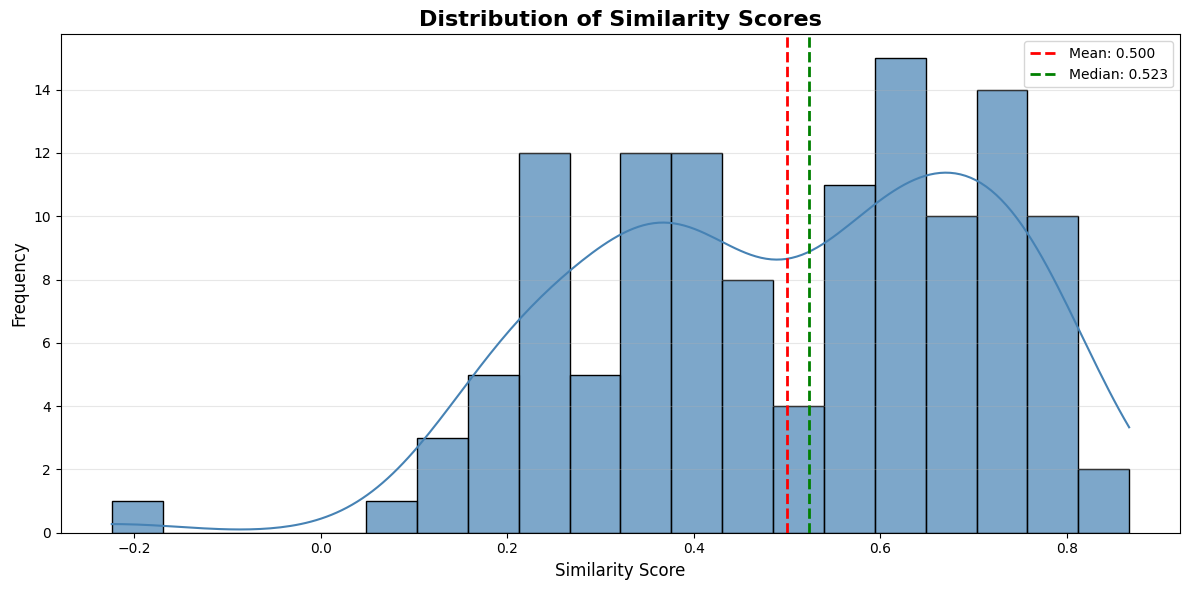

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert to regular floats
similarity_scores = [float(x) for x in similarity]

# Create the plot
plt.figure(figsize=(12, 6))

# Histogram with KDE
sns.histplot(similarity_scores, bins=20, kde=True, color='steelblue', alpha=0.7)

plt.title('Distribution of Similarity Scores', fontsize=16, fontweight='bold')
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add statistics as text
mean_val = np.mean(similarity_scores)
median_val = np.median(similarity_scores)
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')

plt.legend()
plt.tight_layout()
plt.savefig('dist.png', dpi=300)
plt.show()